## Imports and definitions

In [190]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import infercnvpy as cnv
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scripts.utils import load_from_pickle, save_to_pickle, get_sample_ids
import warnings
warnings.filterwarnings('ignore')


chr_order = ['chr'+str(i) for i in np.arange(1,23)]

def sort_chromosomes(vars,chromsomes = chr_order):
    # Vars is a pandas dataframe with chromosomal annotation
    # This function drops redundant genes and sorts the df by chromoal position

    # Drop redundant from variables
    vars = vars.dropna()
    vars = vars[~((vars['chromosome'] == 'chrM')|(vars['chromosome'] == 'chrX') | (vars['chromosome'] == 'chrY'))]

    # Sort variable to genomic pos
    vars['chromosome'] = vars['chromosome'].cat.set_categories(chromsomes)
    vars = vars.sort_values(['chromosome','start'])

    return(vars)

def add_chromosome_bin_annotation(chr_variable_data, chr_list= chr_order, chromosome_bin_size=5e6):

    annotated_chr_var = pd.DataFrame(columns=chr_variable_data.columns)
    # Loop through each chromosme individually
    for chr_name in chr_list:
        # Subset the variables of a specific chromosome
        var_df = chr_variable_data[chr_variable_data['chromosome'] == chr_name].copy()

        # Loop through the genomic coordinates
        prev_coord = None
        prev_category = None

        for i, coord in enumerate(var_df['start']):
            if prev_coord is None:
                # First coordinate, create a new category
                var_df.at[var_df.index[i], 'chromosome_bin'] = chr_name+'.1'
                prev_coord = coord
                prev_category = chr_name+'.1'
            elif coord - prev_coord <= chromosome_bin_size:
                # Within 5 million, assign to same category as previous
                var_df.at[var_df.index[i], 'chromosome_bin'] = prev_category
            else:
                # Outside 5 million, create a new category
                new_category = f'{chr_name}.{int(prev_category.split(".")[-1])+1}'
                var_df.at[var_df.index[i], 'chromosome_bin'] = new_category
                prev_coord = var_df.at[var_df.index[i], 'end'] # Reel to the end of the gene and begin from there
                prev_category = new_category
        
        # Concatenate the finished dataframe
        annotated_chr_var = pd.concat([annotated_chr_var,var_df],axis = 0)
    
    return(annotated_chr_var)

def threshold_matrix(matrix, lower_thr, upper_thr, lower_thr2, upper_thr2):

    # Between the lowest and the second lowest threshold
    below_thr2 = np.where((matrix > lower_thr) & (matrix < lower_thr2), -1, 0)

    # Between the highest and the second highest threshold
    above_thr2 = np.where((matrix < upper_thr) & (matrix > upper_thr2), 1, 0)

    # Below the lowest threshold
    below_thr = np.where(matrix < lower_thr, -2, 0)

    # Above the highest threshold
    above_thr = np.where(matrix > upper_thr, 2, 0)
    result = below_thr + above_thr + below_thr2 + above_thr2
    return result


## Runnning infercnvpy (done already in a script)

In [ ]:
## ALL OF THIS HAS BEEN DONE IN 'infercnvpy_on_visium.py'

adata = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

adata_concat = ad.concat(adata)

# Extract the string before '-' or '_' in each entry
adata_concat.obs['phenotype'] = [entry.split('-')[0].split('_')[0] for entry in adata_concat.obs['sample_id']]

## Get the chromosomal coordinates
cnv.io.genomic_position_from_gtf('./gencode.v43.annotation.gtf', adata_concat)


# Filter the chromosomal coordinates
adata_concat = adata_concat[:,sort_chromosomes(adata_concat.var).index].copy()

# Save the coordinates
vars = adata_concat.var.copy()
vars.to_csv('genomic_positions_infercnvpy_formatted.csv')

## create an anndata object of BPH luminal epithelial cells that will be used as ref.

ref_cat = {'BPH_688':['5','6'],
            'BPH_665':['2'],
            'BPH_651':['1']}

subset_data = []

for idx, row in adata_concat.obs.iterrows():
    sample_id = row['sample_id']
    cluster = row['joint_leiden_clusters']
    if sample_id in ref_cat and cluster in ref_cat[sample_id]:
        subset_data.append(row)

df_subset = pd.DataFrame(subset_data)
ref_subset = adata_concat[df_subset.index]

infercnv_dict = {}
n_samples = len(samples)
count = 1
for sample in samples:
    if 'BPH' not in sample:

        adata_subset = adata_concat[adata_concat.obs['sample_id']==sample]

        adata_subset = ad.concat([adata_subset,ref_subset],join='outer')

        if (adata_subset.var_names == ref_subset.var_names).all():
            adata_subset.var = ref_subset.var.copy()
        
        # Normalize separately to ensure even, comparable distributions
        adata_subset.X = adata_subset.layers['counts']
        sc.pp.normalize_total(adata_subset)
        sc.pp.log1p(adata_subset)


        cnv.tl.infercnv(
        adata_subset,
        reference_key="phenotype",
        reference_cat=['BPH'],
        window_size=101,
        step=1
        )

        infercnv_dict[sample] = adata_subset
        print('Sample ' +sample+ ' processed: '+ str(count)+'/'+str(n_samples))
        print('')
    count+=1

save_to_pickle(infercnv_dict,'dict_with_visium_and_infercnv.pkl')

In [ ]:
for sample in samples:
    if 'BPH' not in sample:
        dat = infercnv_dict[sample].copy()
        dat.obs['cluster'] = dat.obs['sample_id'] + '_' + dat.obs['joint_leiden_clusters']

        # Replace entries with 'ref' if the entry string contains 'BPH', else keep the entry as it was
        dat.obs['cluster'] = ['ref' if 'BPH' in entry else entry for entry in dat.obs['cluster']]

        # Subjective choice of having ther ref plotted alongside (not much to see...)
        dat = dat[dat.obs['cluster']!='ref']
        # Manually clipping the values as a workaround for a bug in the source code
        # as per https://github.com/icbi-lab/infercnvpy/issues/38

        dat.var['chromosome'] = dat.var['chromosome'].cat.set_categories(chr_order)

        dat.obsm["X_cnv"].data = np.clip(dat.obsm["X_cnv"].data, -0.3, 0.3)

        fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

        cnv.pl.chromosome_heatmap(dat,groupby="cluster", figsize=(12,8),
        show=False)

        plt.savefig('./plots/infercnv_maps_20230808/'+sample+'_infercnv_map.png')
        plt.clf()

## Loading and formatting inferCNV results

In [ ]:
infercnv_dict = load_from_pickle('dict_with_visium_and_infercnv.pkl')
samples = get_sample_ids()

# Check quantiles to have an idea of suitable thresholds
infercnv_results_ravel = np.empty(0)
for k in infercnv_dict:
    infercnv_results_ravel = np.hstack([infercnv_results_ravel,infercnv_dict[k].obsm['X_cnv'].data])


In [ ]:
# Test different thresholds of all infercnv values

for lim in [0.01, 0.02, 0.05, 0.1]:

    thr_low = np.quantile(infercnv_results_ravel,0+lim)
    thr_hi = np.quantile(infercnv_results_ravel,1-lim)

    print('limit: ' + str(lim))
    print('Upper: {:.3f}, Lower: {:.3f}'.format(thr_hi,thr_low))
    print(' ')

    dat = infercnv_dict['PC_02_05601_OIK'].copy()

    x_cnv = dat.obsm['X_cnv'].copy().todense()
    x_cnv_thr = threshold_matrix(x_cnv,thr_low,thr_hi)

    dat.obsm['X_cnv'] = x_cnv_thr


    dat.obs['cluster'] = dat.obs['sample_id'] + '_' + dat.obs['joint_leiden_clusters']

    # Replace entries with 'ref' if the entry string contains 'BPH', else keep the entry as it was
    dat.obs['cluster'] = ['ref' if 'BPH' in entry else entry for entry in dat.obs['cluster']]

    # Subjective choice of having ther ref plotted alongside (not much to see...)
    dat = dat[dat.obs['cluster']!='ref']
    # Manually clipping the values as a workaround for a bug in the source code
    # as per https://github.com/icbi-lab/infercnvpy/issues/38

    cnv.pl.chromosome_heatmap(dat,groupby="cluster", figsize=(12,8),show=True)


## Averaging across chromosomal positions

In [ ]:
CI_dict = {}
for ci in [0.01,0.02,0.05,0.1,0.2,0.25]:
    CI_dict[ci] = np.quantile(infercnv_results_ravel,ci)
    CI_dict[1-ci] = np.quantile(infercnv_results_ravel,1-ci)

In [ ]:
signif_thr = 0.01
upper_limit = CI_dict[signif_thr]
lower_limit = CI_dict[1-signif_thr]

signif_thr2 = 0.1
second_upper = CI_dict[signif_thr2]
second_lower = CI_dict[1-signif_thr2]


xmin = -0.25
xmax = 0.25

plt.figure(figsize=(5,4),dpi=120)
plt.hist(infercnv_results_ravel,bins=np.arange(xmin,xmax,0.025))
plt.xlim(xmin, xmax)

# Draw 0.75 confidence intervals
plt.axvline(x=second_upper, color='red', linestyle='dashed')
plt.axvline(x=second_lower, color='red', linestyle='dashed')

plt.axvline(x=lower_limit, color='black', linestyle='dashed')
plt.axvline(x=upper_limit, color='black', linestyle='dashed')

print('Lower significance threshold: {:.3f}'.format(lower_limit))
print('Upper significance threshold: {:.3f}'.format(upper_limit))
plt.show()

... storing 'sample_id' as categorical
... storing 'joint_leiden_clusters' as categorical
... storing 'phenotype' as categorical
... storing 'cluster' as categorical


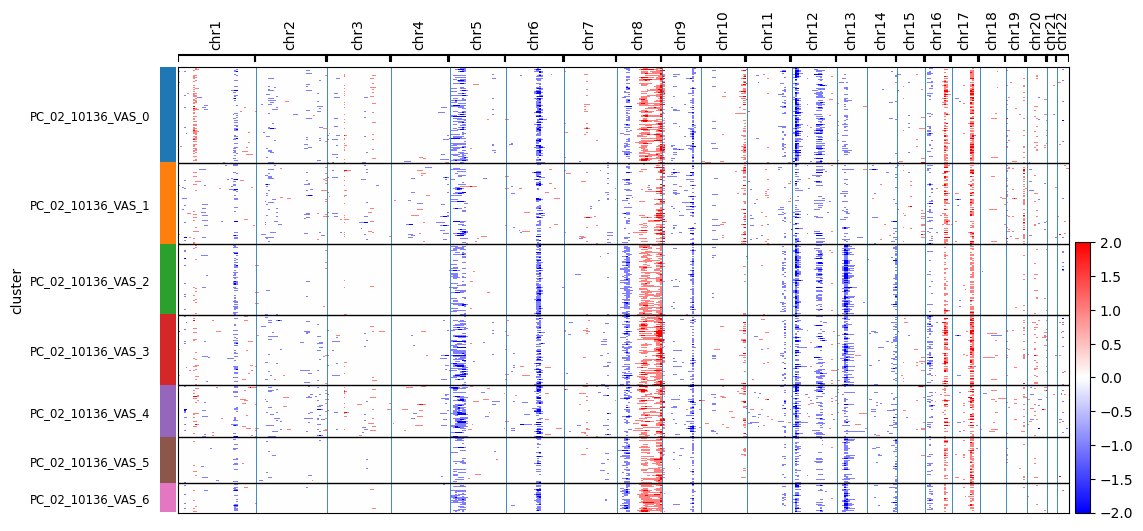

In [213]:
window_size = 5e6
signif_thr = 0.01
signif_thr2 = 0.1

averaged_cnv_data_dict = {}

#for sample in infercnv_dict.keys():
sample = 'PC_02_10136_VAS'

dat = infercnv_dict[sample].copy()
dat.obs['cluster'] = dat.obs['sample_id'] + '_' + dat.obs['joint_leiden_clusters']

# Replace entries with 'ref' if the entry string contains 'BPH', else keep the entry as it was
dat.obs['cluster'] = ['ref' if 'BPH' in entry else entry for entry in dat.obs['cluster']]

# Subjective choice of having ther ref plotted alongside (not much to see...)
dat = dat[dat.obs['cluster']!='ref']

cnv_dat = ad.AnnData(X=dat.obsm['X_cnv'].copy().todense(),obs=dat.obs.copy(),var=dat.var.copy())

cnv_dat = cnv_dat[:,sort_chromosomes(cnv_dat.var).index]
##############################################################################


# Bin the genes (5M base bins by default)

annotated_chr_var = add_chromosome_bin_annotation(cnv_dat.var.copy(),chromosome_bin_size=window_size)

cnv_dat = cnv_dat[:,annotated_chr_var.index] # THIS IS THE PLACE WHERE THE ORDER IS MIXED


#if (annotated_chr_var.index == cnv_dat.var.index).all():
#    cnv_dat.var = annotated_chr_var.copy()
cnv_dat.var = pd.merge(cnv_dat.var,annotated_chr_var['chromosome_bin'],right_index=True, left_index=True,how='left').copy()


##############################################################################

# Summarize data by variables

X = cnv_dat.X.copy()
var_data = cnv_dat.var.copy().reset_index(drop=True)

sum_categories = var_data['chromosome_bin'].unique()

N_obs = X.shape[0]
N_var = len(sum_categories)
X_summed = np.empty((N_obs, N_var))

for i,chr_bin in enumerate(sum_categories):

    idxs = var_data[var_data['chromosome_bin'] == chr_bin].index
    X_summed[:,i] = X[:,idxs].mean(axis=1)

# Create a new anndata object with summarized data
cnv_data_summarized = ad.AnnData(X=X_summed,obs=cnv_dat.obs.copy(),var = pd.DataFrame(index=pd.CategoricalIndex(sum_categories).set_categories(sum_categories)))

# Threshold, sort and plot
cnv_data_summarized.X = threshold_matrix(cnv_data_summarized.X,CI_dict[signif_thr],CI_dict[1-signif_thr],CI_dict[signif_thr2],CI_dict[1-signif_thr2]) # This are the 0.02 and 0.98 quantiles
#cnv_data_summarized = cnv_data_summarized[:,sum_categories] # Sort the cnv data

##############################################################################

# Add chromosome breakpoints into the data

chr_pos_dict = {}
var_group_positions = []
for i,c in enumerate(list(chr_order)):
    
    idxs = np.where([c+'.' in idx for idx in cnv_data_summarized.var.index])[0]
    chr_pos_dict[c] = idxs[0]
    var_group_positions.append((idxs[0],idxs[-1]))

chr_pos = list(chr_pos_dict.values())


##############################################################################

return_ax_dic = sc.pl.heatmap(cnv_data_summarized,var_names=cnv_data_summarized.var_names,groupby='cluster',cmap='bwr',
                                vcenter=0, vmin = -2, vmax = 2, figsize=(12,6), show=False,
            var_group_positions=var_group_positions, var_group_labels=list(chr_pos_dict.keys()))
return_ax_dic['heatmap_ax'].vlines(chr_pos[1:], lw=0.6, ymin=-1, ymax=len(cnv_data_summarized))

averaged_cnv_data_dict[sample] = cnv_data_summarized

#plt.savefig('./plots/infercnv_maps_20230808/'+sample+'_{:.0e}_binned_events_infercnv_map.pdf'.format(window_size))
#plt.clf()
plt.show()

In [ ]:
# Saving data for annotation
from scipy.sparse import save_npz

dat = infercnv_dict['PC_02_05601_OIK'].copy()
dat.var.to_csv('icnv_annotation/gene_annotations.csv')
dat.obs.to_csv('icnv_annotation/obs_annotations.csv')
save_npz('icnv_annotation/icnv_data.npz',dat.obsm['X_cnv'])